# General ABCD Matrix Solver and Ray Tracing


Created July 2017 by Jenny Wu, revised Nov 2019 by Shira Jackson

## Introduction

### ABCD Matrices
The ABCD matrix of an optical component or system of components relates the output ray to the input according to

$$\begin{pmatrix} r'\\ \theta ' \end{pmatrix} = \begin{pmatrix} A&B\\C&D \end{pmatrix} \begin{pmatrix} r\\ \theta \end{pmatrix}$$
where $r$ and $\theta$ represented the height of a ray from the optical axis and the angle that it makes with the optical axis. 

Some typical ABCD matrices are:

| Element                          | Matrix                                                                                 |
|----------------------------------|----------------------------------------------------------------------------------------|
| Free space                       | $\begin{pmatrix} 1 & d\\ 0 & 1 \end{pmatrix} $                                         |
| Thin lens                        | $ \begin{pmatrix} 1 & 0 \\ -\frac{1}{f} & 1 \end{pmatrix} $                            |
| Reflection from a curved mirror  | ${\displaystyle {\begin{pmatrix}1&0\\-{\frac {2}{R}}&1\end{pmatrix}}}$             |
| Refraction at a flat interface   | $\begin{pmatrix} 1 & 0 \\ 0 & \frac{n_1}{n_2} \end{pmatrix} $                          |
| Refraction at a curved interface | $\begin{pmatrix} 1 & 0 \\ \frac{n_1-n_2}{R \cdot n_2} & \frac{n_1}{n_2} \end{pmatrix}$ |

*$R$ = radius of curvatuve

*$n$ = index of refraction

This code includes functions for free space, refraction, thick lens, achromatic lens, and aperture. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize

# refractive index of various lens materials at 398nm
nbk7=1.5311
sf5 = 1.7139
nbaf10 = 1.6965
nsf6ht = 1.8697
slah64 = 1.8186
b270 = 1.54
fusi = 1.4703
nssk5=1.6825
lafn7 = 1.7912
hlak54 = 1.7543

# dot product for handling multiple abcd matrices
def dot_multi(transformations):
    prod = transformations[0].matrix
    for tr in transformations[1:]:
        prod = np.dot(prod, tr.matrix)
    return prod

# general ABCD matrix parent class
class ABCD:
    def __init__(self):
        self.matrix = np.matrix([[0,0],[0,0]])
        self.thickness = 0
        self.components = []

    def apply_transformation(self, v):
        """Applies transformation to a ray in the form (r, theta, z) where
        r is the radial distance from the axis
        theta is the angle from the axis
        z is the distance along the axis"""
        # if the object is multi-component (i.e. a thick lens) then apply
        # transformations individually to allow special handling within the
        # specific basic classes
        if len(self.components) > 0:
            vp = v
            for component in self.components:
                vp = component.apply_transformation(vp)
            return vp
        return np.append(np.array(np.dot(self.matrix,v[:2])).flatten(),v[2]+self.thickness)

    def plt_points(self, v):
        """Returns the (r,z) points that result from this ABCD transformation
        required to plot the ray"""
        if len(self.components) > 0:
            # if the object is multi-component (i.e. a thick lens) then apply
            # transformations individually to allow special handling within the
            # specific basic classes, allows for drawing of multiple refractions
            # within one complex component
            r_arr = []
            z_arr = []
            vp = v
            for component in self.components:
                vp = component.apply_transformation(vp)
                if component.thickness > 0:
                    r_arr.append(vp[0])
                    z_arr.append(vp[2])
            return r_arr, z_arr
        return self.apply_transformation(v)[0::2]

    def draw_self(self, pos):
        pass

# free travel ABCD matrix
class free_travel(ABCD):
    def __init__(self, dist):
        ABCD.__init__(self)
        self.matrix = np.matrix([[1, dist],[0,1]])
        self.thickness = dist
        self.diameter = np.inf

# refraction ABCD matrix
class refraction(ABCD):
    def __init__(self, n1, n2, r):
        """n1 is the refractive index at the entry, n2 refractive index of the next medium"""
        ABCD.__init__(self)
        self.matrix = np.matrix([[1, 0],[(n1-n2)/(r*n2),n1/n2]])
        self.thickness = 0
        self.diameter = np.inf


# aperture, defined as unitary matrix with a certain diameter
class aperture(ABCD):
    def __init__(self, diameter, height = 5):
        ABCD.__init__(self)
        self.matrix = np.array([[1,0],[0,1]])
        self.thickness = 0
        self.diameter = diameter
        self.height = height

    def draw_self(self, pos):
        """Draw as two lines at the diameter."""
        plt.plot([pos]*2, [self.diameter/2 + self.height, self.diameter/2], 'k')
        plt.plot([pos]*2, [-self.diameter/2 - self.height, -self.diameter/2], 'k')

# thick lens ABCD matrix (two refractions sandwiching a free travel matrix)
class thicklens(ABCD):
    def __init__(self, r1, r2, n, t, diameter=np.inf):
        ABCD.__init__(self)
        self.components = np.array([refraction(1,n,r1),free_travel(t),refraction(n,1,r2)])
        self.matrix = dot_multi(self.components[::-1])
        self.thickness = t
        self.diameter = diameter
        self.f = -1/self.matrix[1,0]

    def draw_self(self, pos):
        """Draw square block representing rough size of lens"""
        x0 = pos
        x1 = pos+self.thickness
        y0 = -self.diameter/2
        y1 = self.diameter/2

        plt.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0], '--')

# achromat ABCD matrix (three refractions with free travels in between)
class achromat(ABCD):
    def __init__(self,r1, r2, r3, n1, n2, t1, t2, diameter=np.inf):
        ABCD.__init__(self)
        self.components = np.array([refraction(1,n1,r1),free_travel(t1),refraction(n1,n2,r2), free_travel(t2),refraction(n2,1,r3)])
        self.matrix = dot_multi(self.components[::-1])
        self.thickness = t1+t2
        self.thicknesses = [t1,t2]  # for drawing we need to keep track of the individual thicknesses
        self.diameter = diameter
        self.f = -1/self.matrix[1,0]

    def draw_self(self, pos):
        """The drawing has to be a two-segmented lens"""
        x0 = pos
        x1 = pos+self.thickness
        y0 = -self.diameter/2
        y1 = self.diameter/2

        plt.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0], '--')
        plt.plot([pos + self.thicknesses[0]]*2, [y0,y1], '--')

# create a h and z array for ray v passing through a series of matrices,
# *** in the order that the ray passes through them,
# i.e. in the opposite order that they would be listed in a series of ray transfer matrices
def draw_ray(v, mats):
    # grab first points
    h = np.array([v[0]])
    z = np.array([v[2]])

    for mat in mats:
        # (note that plt_points doesn't actually return the new ray vector so we have to do that later)
        h_new, z_new = mat.plt_points(v)

        # change the ray into the new ray
        v = mat.apply_transformation(v)

        # if the ray exceeds the diameter, the ray exits the system, so stop drawing the ray there
        #if np.abs(v[0]) > mat.diameter/2:
        #    return h,z

        # get new points and append them
        h = np.append(h,h_new)
        z = np.append(z,z_new)

    return h, z



Here is an example use of the code showing a simple telescope using Thorlabs lenses LBF254-100-A and LA1951-A. 

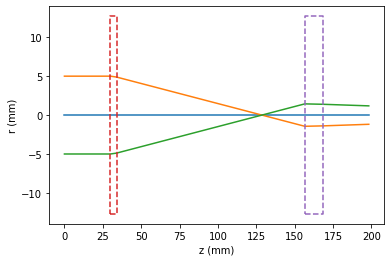

In [2]:
f1 = 97.3
f2 = 25.3

# thicklens parameters are r1, r2, n, t, diameter=np.inf as above
lens1 = thicklens(60.02,-353.3,nbk7,4.0,25.4)
telescope_length = free_travel(f1+f2)
lens2 = thicklens(13.1,np.inf,nbk7,11.7,25.4)


# initial beam waist and divergence in radians
start_waist = 5.0
start_divergence = 0.0

# stack the optical components from first encountered to last
matrices = [free_travel(30),lens1,telescope_length,lens2,free_travel(30)]

abcd = dot_multi(matrices[::-1]) #matrix multiply in reverse order

# generate some test rays to pass through system
h0_arr = [0,start_waist,-start_waist]     # beginning vertical positions of rays, correspond to size of beam
theta0_arr = [0,start_divergence/4,-start_divergence/4] #beam start divergence in radians
z0_arr = [0,0,0] #starting z (should all be the same but can start at an arbitrary z if desired)

# v is a list of [h,theta,z] parameters describing the ray, where h is height, z is z position, theta is angle of divergence
v0s = [[h0_arr[i],theta0_arr[i],z0_arr[i]] for i in range(3)]

h_arr = []
z_arr = []

for v in v0s:
    h,z = draw_ray(v,matrices)
    h_arr.append(h)
    z_arr.append(z)

# draw a figure
plt.figure()
plt.xlabel("z (mm)")
plt.ylabel("r (mm)")


for i in range(3):
    plt.plot(z_arr[i],h_arr[i])

# draw all the components at their correct positions
pos = z0_arr[0]
for mat in matrices:
    mat.draw_self(pos)
    pos += mat.thickness

plt.show()

## Another implementation

This implementation may be a bit simpler to understand. 

Remember that a "ray" is a classical particle picture of a photon, and so it is represented by a point in phase space. The transverse coordinate, perpendicular to the optical axis $z$, is denoted as $x$. Note that $\frac{dx}{dz} = \frac{p_x}{p_z} \approx \frac{p_x}{p}$ in the paraxial approximation, so that $dx/dz$ is basically the transverse momentum of a photon. So the phase space point representing a ray can be written as $\begin{pmatrix} x \\ p_x/p \end{pmatrix} \approx \begin{pmatrix} x \\ {dx}/{dz} \end{pmatrix}$. 

In [3]:
# Calculate ABCD matrix (transfer matrix) of optical system
# All lengths in mm

import numpy as np
from numpy import sin,cos,tan,arctan,pi,sqrt
import matplotlib.pyplot as plt

I = np.mat(np.eye(2))   # identity matrix

class OpticalElement:
    # generic class for an optical element
    def __init__(self,M = np.matrix(np.identity(2)),label=''):
        self.M = I
        self.label = label
        
    def __repr__(self):
        return str(self.M)

class FreeSpace(OpticalElement):
    def __init__(self,d,label=''):
        self.M = np.matrix( [[1,d],[0,1]] )
        self.label = label

class ThinLens(OpticalElement):
    def __init__(self,f,label=''):
        self.M = np.matrix( [[1,0],[-1/f,1]] )

class OpticalSystem(OpticalElement):
    def __init__(self,system_list,label=''):
        # optical elements in order from left to right, input plane is at left
        self.system_list = system_list
        self.label = label
        self.M = I
        for element_i in system_list: self.M = element_i.M * self.M 

class Ray:
    def __init__(self,vector):
        # using convention that ray vector is [ [x],[dx/dz] ]
        self.vector = vector
        
    def __repr__(self):
        return str(self.vector)
        
def propagate(optical_system,ray):
    # matrix multiply transfer matrix and input vector
    return Ray(optical_system.M * ray.vector)   

### Examples

In [4]:
## example 1
input_ray = Ray( np.matrix([[3],[0]]) )

optical_system = OpticalSystem([FreeSpace(20),ThinLens(10),FreeSpace(20)])

output_ray = propagate(optical_system,input_ray)

print(f"Input ray = \n {input_ray} \n")

print(f"System transfer matrix = \n {optical_system} \n")

print(f"Output ray = \n {output_ray} \n")

Input ray = 
 [[3]
 [0]] 

System transfer matrix = 
 [[-1.   0. ]
 [-0.1 -1. ]] 

Output ray = 
 [[-3. ]
 [-0.3]] 



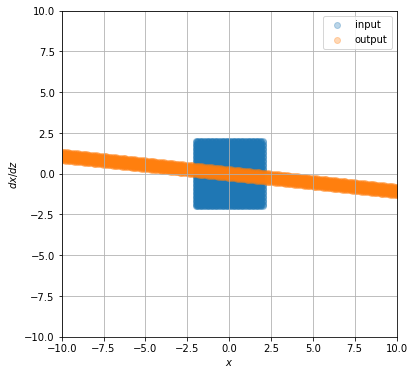

In [5]:
## example 2: propagation of a uniformly distributed bundle of rays
N = 50
input_bundle = []

for i in np.linspace(-2,2,N):
    for j in np.linspace(-2,2,N):
        input_bundle.append( Ray(np.matrix([[i],[j]])) )

output_bundle = []

optical_system = OpticalSystem([ThinLens(3),FreeSpace(7),ThinLens(4)])

for input_ray in input_bundle:
        output_ray = propagate(optical_system,input_ray)
        output_bundle.append(output_ray)

x_values = [i.vector[0][0,0] for i in input_bundle]
dx_dz_values = [i.vector[1][0,0] for i in input_bundle]

x_out_values = [i.vector[0][0,0] for i in output_bundle]
dx_dz_out_values = [i.vector[1][0,0] for i in output_bundle]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(x_values,dx_dz_values, alpha=0.3,label="input")
ax.scatter(x_out_values,dx_dz_out_values, alpha=0.3,label="output")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"${dx}/{dz}$")
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.legend()
ax.grid()
plt.show()

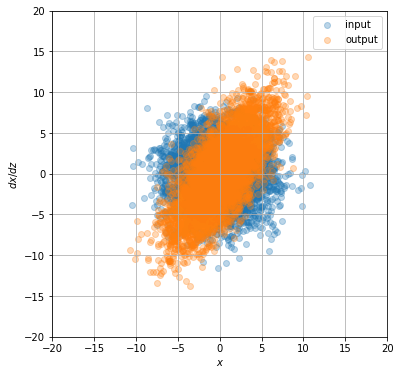

In [6]:
## example 3: propagation of a gaussian bundle of rays
N = 5000

input_bundle = [ Ray( np.matrix( np.random.normal((0,0),3) ).T) for i in range(N) ]

output_bundle = []

optical_system = OpticalSystem([FreeSpace(2),ThinLens(1),FreeSpace(2)])

for input_ray in input_bundle:
        output_ray = propagate(optical_system,input_ray)
        output_bundle.append(output_ray)

x_values = [i.vector[0][0,0] for i in input_bundle]
dx_dz_values = [i.vector[1][0,0] for i in input_bundle]

x_out_values = [i.vector[0][0,0] for i in output_bundle]
dx_dz_out_values = [i.vector[1][0,0] for i in output_bundle]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(x_values,dx_dz_values, alpha=0.3,label="input")
ax.scatter(x_out_values,dx_dz_out_values, alpha=0.3,label="output")
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"${dx}/{dz}$")
ax.legend()
ax.grid()
plt.show()